In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# `AvoidObserver`
- SAIDA_RL에서 작성한 document : https://teamsaida.github.io/SAIDA_RL/AvoidObserver/

---
## #1. import AvoidObserver

- `AvoidObserver` 클래스를 import 해서 env를 만들면 학습시킬 수 있는 환경 객체가 생성된다.

In [2]:
from saida_gym.starcraft.avoidObservers import AvoidObservers

In [3]:
frames_per_step = 4
no_gui = False

env = AvoidObservers(action_type=0, verbose=0, frames_per_step=frames_per_step, no_gui=no_gui, \
                     bot_runner=r"..\SAIDA_RL\cpp\Release\SAIDA\SAIDA.exe")

Initialize...
Shared Memory create 
SAIDA_AO6140 Shared memory found.


- env 객체를 생성하기만 해도 starcraft 환경이 켜짐. 


- `python/saida_gym/envs/SAIDAGym.py` 에서 `shm.SharedMemory()` 로 메모리를 공유하면서 바로 켜지는 것으로 보임.

In [4]:
s = env.reset()
s

my_unit {
  pos_x: 1024
  pos_y: 1984
  angle: 4.71238898038469
}
en_unit {
  pos_x: 1179
  pos_y: 1753
  velocity_x: -0.1875
  velocity_y: -0.1015625
  angle: 3.141592653589793
}
en_unit {
  pos_x: 797
  pos_y: 1775
  velocity_x: -0.0234375
  velocity_y: -0.2109375
  angle: 4.123340357836604
}
en_unit {
  pos_x: 731
  pos_y: 1965
  velocity_x: -0.1875
  velocity_y: 0.09765625
  angle: 2.1598449493429825
}
en_unit {
  pos_x: 928
  pos_y: 1686
  velocity_x: -0.0625
  velocity_y: 0.19921875
  angle: 2.356194490192345
}

---
## #2. `State` : 64x64로 전체 지도 그리기


In [5]:
def process_observation(observation, last_action=None, verbose=False):
    LOCAL_OBSERVABLE_TILE_SIZE = 10

    # scurge's map
    map_of_scurge = np.zeros(shape=(64, 64))

    me_x = observation.my_unit[0].pos_x
    me_y = observation.my_unit[0].pos_y

    me_x_t = np.clip(int(me_x/32), 0, 64)
    me_y_t = np.clip(int(me_y/32), 0, 64)
    if verbose:
        print('my location:', [me_x_t, me_y_t])

    # Safe zone : left-top (896, 1888) right-bottom (1056, 2048) with additional (marginal) space
    for x in range(int(896/32), int(1056/32)): # 28~33
        for y in range(int(1888/32), int(2048/32)): # 59~64
            map_of_scurge[y][x] = -1  # masking safe zone

    # Goal line : left-top (0, 0) right-bottom (2048, 64) with additional (marginal) space
    for x in range(int(0/32), int(2048/32)): # 0~64
        for y in range(int(0/32), int(64/32)): # 0~2
            map_of_scurge[y][x] = -1  # masking safe zone

    # masking observer's location
    map_of_scurge[me_y_t][me_x_t] = 1
    #map_of_scurge = np.expand_dims(map_of_scurge, -1)

    # observer map
    map_of_observer = np.zeros(shape=(LOCAL_OBSERVABLE_TILE_SIZE*2+1, LOCAL_OBSERVABLE_TILE_SIZE*2+1))
    map_of_observer[LOCAL_OBSERVABLE_TILE_SIZE, LOCAL_OBSERVABLE_TILE_SIZE] = -1

    for ob in observation.en_unit:
        en_x_t = ob.pos_x / 32
        en_y_t = ob.pos_y / 32

        # scurge를 중앙에 두기 위해
        rel_x = int(en_x_t - me_x_t) + LOCAL_OBSERVABLE_TILE_SIZE
        rel_y = int(en_y_t - me_y_t) + LOCAL_OBSERVABLE_TILE_SIZE

        rel_x = np.clip(rel_x, 0, LOCAL_OBSERVABLE_TILE_SIZE*2-1)
        rel_y = np.clip(rel_y, 0, LOCAL_OBSERVABLE_TILE_SIZE*2-1)
        if verbose:
            print('enemy location:', [en_x_t, en_y_t], '(relevant:', [rel_x, rel_y], ')')

        map_of_observer[rel_y][rel_x] = map_of_observer[rel_y][rel_x] + 1  # if two or more observers are duplicated, we use sum

    # display out of map where scurge can't go based on current location of scurge
    scurge_out_of_map_left = me_x_t - LOCAL_OBSERVABLE_TILE_SIZE
    scurge_out_of_map_right = me_x_t + LOCAL_OBSERVABLE_TILE_SIZE
    scurge_out_of_map_up = me_y_t - LOCAL_OBSERVABLE_TILE_SIZE
    scurge_out_of_map_down = me_y_t + LOCAL_OBSERVABLE_TILE_SIZE

    if scurge_out_of_map_left < 0:
        map_of_observer[:, 0:-scurge_out_of_map_left] = -2
    if scurge_out_of_map_right > 64:
        map_of_observer[:, -(scurge_out_of_map_right-64):] = -2
    if scurge_out_of_map_up < 0:
        map_of_observer[0:-scurge_out_of_map_up,:] = -2
    if scurge_out_of_map_down > 64:
        map_of_observer[-(scurge_out_of_map_down-64):,:] = -2

    #map_of_observer = np.expand_dims(map_of_observer, -1)

    if not last_action:
        last_action = np.full((64, 64), -1)
    else:
        last_action = np.full((64, 64), last_action)
        
    if verbose:
        print(map_of_scurge.shape)
        print(map_of_observer.shape)
        print(last_action.shape)
    
    return [map_of_scurge, map_of_observer, last_action]

In [6]:
[map_of_scurge, map_of_observer, last_action] = process_observation(s)

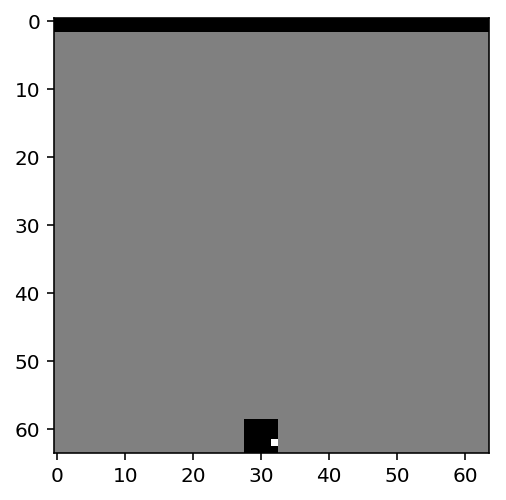

In [7]:
plt.imshow(map_of_scurge, cmap='gray')
plt.show()

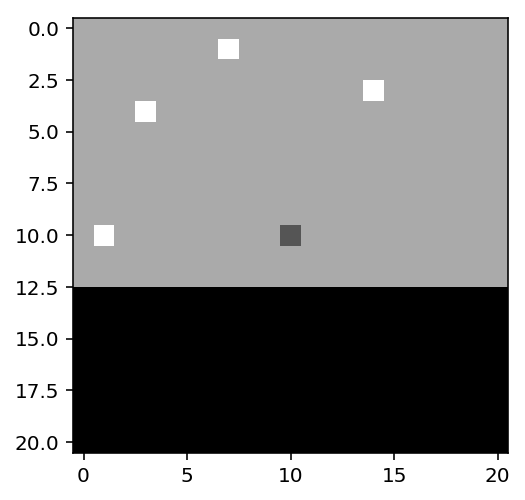

In [8]:
plt.imshow(map_of_observer, cmap='gray')
plt.show()

---

##  #3. 그 외의 파라미터

### 1) 학습과 관련된 parameters

In [11]:
env.__dict__.keys()

dict_keys(['verbose', 'action_type', 'map_version', 'frames_per_step', 'move_angle', 'move_dist', 'conn', 'message', 'common_message', 'init_req_msg', 'init_res_msg', 'reset_req_msg', 'reset_res_msg', 'step_req_msg', 'step_res_msg', 'close_req_msg', 'state', 'action_space', 'reward', 'done', 'info'])

In [12]:
print("verbose:", env.verbose)
print("action_type:", env.action_type)
print("map_version:", env.map_version)
print("frames_per_step:", env.frames_per_step)
print("move_angle:", env.move_angle)
print("move_dist:", env.move_dist)
print("action_space:", env.action_space)

verbose: 0
action_type: 0
map_version: 0
frames_per_step: 4
move_angle: 30
move_dist: 4
action_space: Discrete(13)


#### # `verbose`
- 출력되는 로그의 양 조정

#### # `action_type`
- `0` : discrete (output : descrete한 N개의 action_space 중 하나의 `integer` (0~N 중 마지막 숫자인 N은 공격))
- `1` : continuous, xy좌표 (output : `[x좌표, y좌표, action_종류(0:이동, 1:공격)]`)
- `2` : continuous, 극좌표 (output : `[theta, radian, action_종류(0:이동, 1:공격)]`)
    
#### # `map_version` 
- `0` : 1 vulture versus 1 zealot, no terrain
- `1` : 1 vulture versus 2 zealot, no terrain	
- `2` : 1 vulture versus 1 zealot, with terrain
- `3` : 1 vulture versus 2 zealot, with terrain

#### # `frames_per_step`
- 몇 frame마다 하나의 action을 결정할지에 대한 step을 결정

#### # `move_angle`
- 가장 작은 단위의 움직임 각도 단위
- `move_angle = 30` 이면 agent는 30도 단위, 즉 360/30 = 12방향으로 이동가능

#### # `move_dist` 
- 한 action에 이동할 거리
- 1 unit = 32px 

#### # `action_space` 
- `move_angle`로 나뉘어진 action 공간
- `move_angle = 30` 이면 `action_space`는 12개 방향 + 정지 action 1개 = 13개

#### # `observation_space`
- 각 agent (자신과 적 포함) 에게서 관찰할 수 있는 모든 정보 종류의 수

### 2) starcraft server와의 connection과 관련된 parameters

In [13]:
print("conn:", env.conn)
print("message:", env.message)  # protobuf file
print("common_message:", env.common_message)  # protobuf file

conn: <saida_gym.envs.conn.shm.SharedMemory object at 0x00000140613AB710>
message: <module 'saida_gym.envs.protobuf.common_pb2' from 'C:\\Users\\Jeina\\SAIDA_RL\\python\\saida_gym\\envs\\protobuf\\common_pb2.py'>
common_message: <module 'saida_gym.envs.protobuf.common_pb2' from 'C:\\Users\\Jeina\\SAIDA_RL\\python\\saida_gym\\envs\\protobuf\\common_pb2.py'>


- 이 친구들은 connection과 연관이 있음 


- python 코드에서 cpp 코드로 넘어가는 부분이기도 함


- python과 cpp 간에 데이터 전송을 protobuf 라는 데이터 구조로 진행하는 것으로 보임, 완벽하게 이해는 x  

### 3) `reward`, `done`, `info`

In [16]:
env.reward

0

- agent의 보상값 (zealot을 죽이면 양의 보상을 받을 것으로 예상)

In [17]:
env.done

0

- episode가 끝났는지에 대한 boolean값

- vulture나 zealot 중 하나가 죽으면 끝날 것으로 예상

In [18]:
env.info

{}